In [1]:
import re
import pandas as pd
from wordcloud import WordCloud
import nltk
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
def remove_punctuation(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(
        r"https?:\/\/(www\.)? ?[-a-zA-Z0-9@:%._\+~#=]{1,256}\. ?[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)",
        "",
        text,
    )
#     text = re.sub(r"[^@#\w\s]", "", text)
    return text

In [3]:
df = pd.read_csv('irony-labeled.csv')

In [4]:
df['comment_text'].apply(remove_punctuation)[0]

"I suspect atheists are projecting their desires when they imagine Obama is one of their number. Does anyone remember the crazy preacher with whom he was associated?  I can understand a career politician in the USA needing to feign belief to get elected, but for that purpose I'd imagine a more vanilla choice of church. He's not an atheist. He's not a liberal either."

In [5]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['im'])
STOPWORDS = set(STOPWORDS)

Text(0.5, 1.0, 'Ironic Comments')

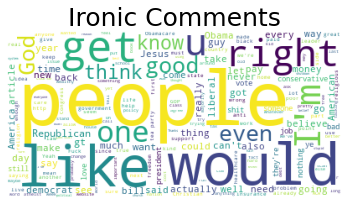

In [6]:



text_ironic = ' '.join(df.comment_text[df['label'] == 1])
wc_ironic = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text_ironic)
plt.imshow(wc_ironic)
plt.axis('off')
plt.title('Ironic Comments',fontsize=25)

Text(0.5, 1.0, 'Regular Comments')

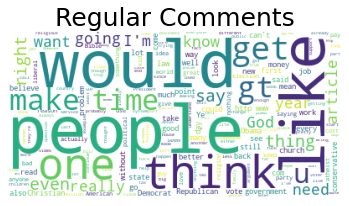

In [7]:
text = ' '.join(df.comment_text[df['label'] == -1])
wc = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Regular Comments',fontsize=25)

In [8]:
#Lista de sentenças irônicas e regulares
# sents_ironic = [item.split() for item in df.comment_text[df['label'] == 1]]
# sents_regular = [item.split() for item in df.comment_text[df['label'] == -1]]
# sents_ironic[0]

In [9]:
def preprocess(sent):

    def convert(word):
        word = re.sub(r"\W+", "", word)
        # Verifica se é um número.
        try:
            _ = float(word)
            return '<num>'
        except:
            pass

        # Verifica se é uma palavra.
        if word.isalpha():
            lower = word.lower()
            return '<stop>' if lower in STOPWORDS else lower

        # Caso contrário, é pontuação ou estranho.
        return '<weird>'

    processed = [convert(word) for word in sent]
    forbidden_words = set(('<num>', '<stop>', '<weird>'))
    return [word for word in processed if word not in forbidden_words]

In [10]:
#Lista de sentenças irônicas e regulares
sents_ironic = [preprocess(item.strip().split()) for item in df.comment_text[df['label'] == 1]]
sents_regular = [preprocess(item.strip().split()) for item in df.comment_text[df['label'] == -1]]

### DOC2VEC

### LDA

In [11]:
import pickle
from gensim.corpora import Dictionary
import gensim

In [12]:
%%time
dictionary_ironic = Dictionary(sents_ironic)
dictionary_regular = Dictionary(sents_regular)

Wall time: 78.8 ms


In [13]:
from gensim.models.ldamulticore import LdaMulticore
def model_dict(sents, filename):
    dictionary = Dictionary(sents)
    corpus = [dictionary.doc2bow(sent) for sent in sents]
    
#     pickle.dump(corpus, open(f'{filename}_corpus.pkl', 'wb'))
#     dictionary.save(f'{filename}_dictionary.gensim')
    
    NUM_TOPICS = 6
    ldamodel = LdaMulticore(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=30)

    return corpus, dictionary, ldamodel

In [14]:
corpus_ironic, dictionary_ironic, lda_model_ironic = model_dict(sents_ironic, 'sents_ironic')
corpus_regular, dictionary_regular, lda_model_regular = model_dict(sents_regular, 'sents_regular')

In [15]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model_ironic, corpus_ironic, sents_ironic)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.4929,"dont, people, us, like, oh, cant, first, yes, ...","[democrats, dont, know, manage, money, shocking]"
1,1,2.0,0.9356,"like, would, dont, wrong, one, going, money, r...","[like, automation, eliminated, need, manual, l..."
2,2,4.0,0.9357,"people, would, get, like, god, us, dont, think...","[insane, like, fox, ted, cruz, actually, intel..."
3,3,4.0,0.9240,"people, would, get, like, god, us, dont, think...","[jesus, destroyed, satan, freedom, still, evil..."
4,4,2.0,0.9240,"like, would, dont, wrong, one, going, money, r...","[reddit, liberal, brigade, would, downvote, ob..."
5,5,2.0,0.9301,"like, would, dont, wrong, one, going, money, r...","[amazing, democrats, view, money, come, somewh..."
6,6,4.0,0.9559,"people, would, get, like, god, us, dont, think...","[makes, cringe, sure, use, memes, try, appeal,..."
7,7,3.0,0.9509,"obama, democrats, us, dont, vote, republicans,...","[question, twitter, qampa, washing, sleaze, re..."
8,8,3.0,0.9402,"obama, democrats, us, dont, vote, republicans,...","[really, pathetic, send, shit, countries, incl..."
9,9,2.0,0.9403,"like, would, dont, wrong, one, going, money, r...","[one, utter, shock, fine, institutions, would,..."


In [16]:
representativeDoc = pd.DataFrame()

groupByDominantTopic = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in groupByDominantTopic:
    representativeDoc = pd.concat([representativeDoc, 
                        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                        axis=0)

# Reset Index    
representativeDoc.reset_index(drop=True, inplace=True)

# Format
representativeDoc.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
representativeDoc

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9873,"people, would, bad, also, christian, single, v...","[point, invite, bc, fanbase, believes, want, s..."
1,1.0,0.9940,"dont, people, us, like, oh, cant, first, yes, ...","[know, earth, vastly, older, years, old, huge,..."
2,2.0,0.9818,"like, would, dont, wrong, one, going, money, r...","[like, video, much, one, promises, end, wire, ..."
3,3.0,0.9940,"obama, democrats, us, dont, vote, republicans,...","[user, tilio, deleted, comment, realizing, stu..."
4,4.0,0.9941,"people, would, get, like, god, us, dont, think...","[definitely, could, construed, form, terrorism..."
5,5.0,0.9977,"would, get, care, people, right, good, know, t...","[prefer, texan, back, horrible, kidney, stone,..."


In [17]:
for i in range(len(representativeDoc)):
    print(f"Topic {i}\n", " ".join(representativeDoc["Text"][i]))
    print('=' * 80)

Topic 0
 point invite bc fanbase believes want see hannity destroy atheists show bc want confirmation bias already know smarter selfish egotistical atheists need gallant knight show slays morrally repugnant leader using reason logic try use agains jesus obviously set hannity good debater go someone ill prepared fast talking gotcha attack journalism well guy ready funny thing christian conservatives watch hannity probably think ol han desroyed atheist
Topic 1
 know earth vastly older years old huge variety reasons name amino acid racemization baptistina asteroid family continental drift coral cosmogenic nuclide dating dendrochronology distant starlight erosion fission track dating geomagnetic reversals helioseismology human ychromosomal ancestry ice layering impact craters ironmanganese nodule growth lack dna fossils length prehistoric day lunar retreat naica megacrystals nitrogen impurities natural diamonds oxidizable carbon ratio dating permafrost petrified wood radioactive decay rela

In [18]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

c:\users\mathe\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [19]:
def display_model(corpus, dictionary, ldamodel):  
    lda_display = pyLDAvis.gensim_models.prepare(
        ldamodel,
        corpus,
        dictionary,
        sort_topics=False,
    )
    return pyLDAvis.display(lda_display)


In [20]:
display_model(corpus_ironic, dictionary_ironic, lda_model_ironic)

In [21]:
display_model(corpus_regular, dictionary_regular, lda_model_regular)